# AutoTrader Challenge

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyarrow # For accessing parquet files
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import PredictionErrorDisplay, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

In [2]:
data_path= f"rate_of_sale_may_2023.snappy.parquet" 

data_dict_path = f"rate_of_sale_data_dict.csv" 

df = pd.read_parquet(data_path) 

category_descriptions = pd.read_csv(data_dict_path) 

In [3]:
df.head(10)



,stock_item_id,last_date_seen,first_date_seen,days_to_sell,first_retailer_asking_price,last_retailer_asking_price,can_home_deliver,reviews_per_100_advertised_stock_last_12_months,segment,seats,...,odometer_reading_miles,first_registration_date,attention_grabber,manufacturer_approved,price_indicator_rating,adjusted_retail_amount_gbp,predicted_mileage,number_of_images,advert_quality,postcode_area
0,52ae009b671ab58b3d4ff109a9fbdcf8d847de0fa190e1...,2023-05-05,2021-03-25,771,6995,6495.0,False,3.9,Independent,5.0,...,65000,2004-05-07,*IMMACULATE**FULL HISTORY*,False,NOANALYSIS,NaN,NaN,50,NaN,AL
1,32b1bac6934b1f64ff43cffa9df5aa296ead8143c36f9f...,2023-05-09,2021-05-25,714,13725,14995.0,False,NaN,Franchise,5.0,...,16018,2019-11-30,Sports Styling | Great Economy,True,GOOD,14848.0,26078.0,15,57.0,HP
2,21703d22d87eaa95c4dc81a60ba2c8cbe3b90ab659292c...,2023-05-12,2021-11-26,532,15499,13999.0,False,0.2,Independent,5.0,...,31093,2018-03-08,"Sat Nav,Leather,Auto,Euro 6",False,GREAT,14571.0,34732.0,22,61.0,SR
3,661acafc271373946cea7d30ac7f34257404ab89a1ad33...,2023-05-16,2022-02-17,453,10995,9995.0,False,7.9,Franchise,5.0,...,79000,2015-07-02,Viewing by APPOINTMENT ONLY,False,FAIR,9349.0,65684.0,30,61.0,FY
4,638216dc92410d965b416fea5b3cec9ca903368795fdde...,2023-05-04,2022-03-21,409,46000,37500.0,False,6.8,Franchise,5.0,...,10214,2022-03-03,Reserve Online,True,GOOD,37055.0,11765.0,22,48.0,LE
5,e3c8b08856a8736bb48c38f083d42f43f3e3e8e3466610...,2023-05-21,2022-04-27,389,1395,1295.0,False,2.6,Independent,5.0,...,91000,2009-03-25,8 MONTHS MOT,False,NOANALYSIS,2285.0,61512.0,15,NaN,RG
6,82369d8013f2ab13f8f49fb780797298a8dd19974d3b60...,2023-05-14,2022-06-06,342,8257,7457.0,False,NaN,Independent,5.0,...,58849,2015-03-18,"£0 ROAD TAX, 1/2 LEATHER SEATS",False,LOW,8145.0,52450.0,24,54.0,PE
7,1fd13f137d7ed19e993b07dd1708992582537e56efb863...,2023-05-03,2022-06-16,321,23500,19500.0,False,1.2,Independent,5.0,...,40000,2017-11-30,LOW MILEAGE AUTOMATIC,False,NOANALYSIS,24662.0,52255.0,23,44.0,N
8,c34a29671d55abf60ea1ab1c23ad21a0a7437c8ffea756...,2023-05-16,2022-06-23,327,96950,84950.0,False,NaN,Independent,4.0,...,5000,2018-03-29,Mulliner Driving Specification,False,NOANALYSIS,96290.0,23167.0,9,NaN,HP
9,db6f342f73f5c7819fef4254e6886387eac15e026878ab...,2023-05-22,2022-06-24,332,15995,15695.0,False,NaN,Independent,5.0,...,34000,2018-11-07,DEPOSIT TAKEN ON THIS CAR,False,GOOD,15973.0,37233.0,30,65.0,CO


In [4]:
df.isna().sum()

# drop na and work out feature importance first

stock_item_id                                           0
last_date_seen                                          0
first_date_seen                                         0
days_to_sell                                            0
first_retailer_asking_price                             0
last_retailer_asking_price                            929
can_home_deliver                                        0
reviews_per_100_advertised_stock_last_12_months     33266
segment                                                32
seats                                                 129
doors                                                   4
co2_emission_gpkm                                     117
top_speed_mph                                         653
zero_to_sixty_mph_seconds                          143152
engine_power_bhp                                        2
fuel_economy_wltp_combined_mpg                       6868
battery_range_miles                                213494
battery_usable

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224555 entries, 0 to 224554
Data columns (total 42 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   stock_item_id                                    224555 non-null  object 
 1   last_date_seen                                   224555 non-null  object 
 2   first_date_seen                                  224555 non-null  object 
 3   days_to_sell                                     224555 non-null  int32  
 4   first_retailer_asking_price                      224555 non-null  int64  
 5   last_retailer_asking_price                       223626 non-null  float64
 6   can_home_deliver                                 224555 non-null  bool   
 7   reviews_per_100_advertised_stock_last_12_months  191289 non-null  float64
 8   segment                                          224523 non-null  object 
 9   seats          

In [6]:
category_descriptions.head(10)

,Field,Description
0,stock_item_id,Unique ID of the advert e.g. 8a42801e86dad35a0...
1,last_date_seen,The date the vehicle was last seen advertised ...
2,first_date_seen,The first date the vehicle was listed on Auto ...
3,days_to_sell,The difference in days between first_date_seen...
4,first_retailer_asking_price,The price the advert had when first created. T...
5,last_retailer_asking_price,The last seen price
6,can_home_deliver,This advert is able to be delivered to the buy...
7,reviews_per_100_advertised_stock_last_12_months,How many reviews the seller has recieved in th...
8,segment,Whether the seller is a Franchise or Independe...
9,seats,Number of seats in the vehicle


## Data Sanitisation

In [7]:
df.shape

(224555, 42)

### Drop Irrelevant Columns

In [8]:
df = df[df['stock_item_id'] != '6e0bc864bc4906de2ee2f20287772e9f3fa6fd788b7f7e9e29304c7c8c40dcfd']

In [9]:
df = df.drop(columns=['stock_item_id', 'derivative', 'derivative_id', 'generation', 'colour', 'boot_space_seats_up_litres', 'first_registration_date', 'last_date_seen', 'first_date_seen'])

In [10]:
df['zero_to_sixty_mph_seconds'] = df['zero_to_sixty_mph_seconds'].astype(float)
df['engine_power_bhp'] = df['engine_power_bhp'].astype(float)
df['fuel_economy_wltp_combined_mpg'] = df['fuel_economy_wltp_combined_mpg'].astype(float)
df['battery_usable_capacity_kwh'] = df['battery_usable_capacity_kwh'].astype(float)
df['length_mm'] = df['length_mm'].astype(float)
df['insurance_group'] = df['insurance_group'].astype(float)

In [11]:
df = df.dropna(subset=['plate'])
contains_letter = df['plate'].str.contains('[a-zA-Z]', regex=True)
df.loc[contains_letter, 'plate'] = 1

In [12]:
df['plate'] = df['plate'].astype(float)

In [13]:
non_elec = df['fuel_type'].isin(['Petrol', 'Diesel', 'Bi_fuel'])
df.loc[non_elec, 'battery_usable_capacity_kwh'] = 0
df.loc[non_elec, 'battery_range_miles'] = 0

In [14]:
df['battery_usable_capacity_kwh'].isnull().sum()

12944

In [15]:
filtered_df = df[(~df['fuel_type'].isin(['Petrol', 'Diesel', 'Bi_fuel'])) & (df['battery_usable_capacity_kwh'] == 0)]

# Step 2: Compute the mean 'battery_usable_capacity_kwh' for each 'make'
mean_capacity_by_make = df.groupby('make')['battery_usable_capacity_kwh'].mean()

# Step 3: Replace 0 values in 'battery_usable_capacity_kwh' with the mean value per make
for make, mean_capacity in mean_capacity_by_make.items():
    df.loc[(df['make'] == make) & (df['battery_usable_capacity_kwh'] == 0), 'battery_usable_capacity_kwh'] = mean_capacity

In [16]:
df['battery_usable_capacity_kwh'].isnull().sum()

12944

In [17]:
df['price_indicator_rating'].unique()

array(['NOANALYSIS', 'GOOD', 'GREAT', 'FAIR', 'LOW', 'HIGH'], dtype=object)

In [18]:
df['price_indicator_rating'] = df['price_indicator_rating'].replace({'NOANALYSIS': 0, 'GOOD': 1, 'GREAT': 2, 'FAIR': 3, 'LOW': 4, 'HIGH': 5})
df['price_indicator_rating'] = df['price_indicator_rating'].astype(int)
df = df[df['last_retailer_asking_price'] != 1]
df['last_retailer_asking_price'] = df['last_retailer_asking_price'].fillna(df['first_retailer_asking_price'])

In [19]:
df['reviews_per_100_advertised_stock_last_12_months'] = df['reviews_per_100_advertised_stock_last_12_months'].clip(upper=100)

mean_reviews = df['reviews_per_100_advertised_stock_last_12_months'].mean()
df['reviews_per_100_advertised_stock_last_12_months'] = df['reviews_per_100_advertised_stock_last_12_months'].fillna(mean_reviews)



In [20]:
df = df.dropna(subset=['segment'])
df = df.dropna(subset=['doors'])
for sts in df['doors'].unique():
    if df[(df['doors'] == sts) & (df['seats'].isnull())].empty:
        continue
    mseats = df[df['doors'] == sts]['seats'].mode()
    if not mseats.empty:
        df.loc[(df['doors'] == sts) & (df['seats'].isnull()), 'seats'] = mseats.iloc[0]

In [21]:
df.loc[df['fuel_type'] == 'Electric', 'co2_emission_gpkm'] = 0
for emissions in df['fuel_type'].unique():
    if df[(df['fuel_type'] == emissions) & (df['co2_emission_gpkm'].isnull())].empty:
        continue
    emiss = df[df['fuel_type'] == emissions]['co2_emission_gpkm'].mode()
    if not emiss.empty:
        df.loc[(df['fuel_type'] == emissions) & (df['co2_emission_gpkm'].isnull()), 'co2_emission_gpkm'] = emiss.iloc[0]


In [22]:
for mk in df['make'].unique():
    if df[(df['make'] == mk) & (df['model'].isnull())].empty:
        continue
    mdl = df[df['make'] == mk]['model'].mode()
    if not mdl.empty:
        df.loc[(df['make'] == mk) & (df['model'].isnull()), 'model'] = mdl.iloc[0]

In [23]:
for mod in df['model'].unique():
    if df[(df['model'] == mod) & (df['top_speed_mph'].isnull())].empty:
        continue
    tspeed = df[df['model'] == mod]['top_speed_mph'].mode()
    if not tspeed.empty:
        df.loc[(df['model'] == mod) & (df['top_speed_mph'].isnull()), 'top_speed_mph'] = tspeed.iloc[0]

In [24]:
df = df.dropna(subset=['top_speed_mph'])

In [25]:
for tsm in df['model'].unique():
    if df[(df['model'] == tsm) & (df['zero_to_sixty_mph_seconds'].isnull())].empty:
        continue
    zts = df[df['model'] == tsm]['zero_to_sixty_mph_seconds'].mode()
    if not zts.empty:
        df.loc[(df['model'] == tsm) & (df['zero_to_sixty_mph_seconds'].isnull()), 'zero_to_sixty_mph_seconds'] = zts.iloc[0]

In [26]:
for tsm in df['make'].unique():
    if df[(df['make'] == tsm) & (df['zero_to_sixty_mph_seconds'].isnull())].empty:
        continue
    zts = df[df['make'] == tsm]['zero_to_sixty_mph_seconds'].mode()
    if not zts.empty:
        df.loc[(df['make'] == tsm) & (df['zero_to_sixty_mph_seconds'].isnull()), 'zero_to_sixty_mph_seconds'] = zts.iloc[0]

In [27]:
df = df.dropna(subset=['zero_to_sixty_mph_seconds'])
df = df.dropna(subset=['engine_power_bhp'])

In [28]:
for fmpg in df['model'].unique():
    if df[(df['model'] == fmpg) & (df['fuel_economy_wltp_combined_mpg'].isnull())].empty:
        continue
    mwltp = df[df['model'] == fmpg]['fuel_economy_wltp_combined_mpg'].mode()
    if not mwltp.empty:
        df.loc[(df['model'] == fmpg) & (df['fuel_economy_wltp_combined_mpg'].isnull()), 'fuel_economy_wltp_combined_mpg'] = mwltp.iloc[0]

In [29]:
for fmpg in df['make'].unique():
    if df[(df['make'] == fmpg) & (df['fuel_economy_wltp_combined_mpg'].isnull())].empty:
        continue
    mwltp = df[df['make'] == fmpg]['fuel_economy_wltp_combined_mpg'].mode()
    if not mwltp.empty:
        df.loc[(df['make'] == fmpg) & (df['fuel_economy_wltp_combined_mpg'].isnull()), 'fuel_economy_wltp_combined_mpg'] = mwltp.iloc[0]

In [30]:
df['battery_usable_capacity_kwh'] = df['battery_usable_capacity_kwh'].round(2)
df['battery_usable_capacity_kwh'].head(10)

0     2.57
1     0.38
2    13.11
3     0.38
4     1.40
5     2.08
6     0.38
7     1.40
8     0.41
9     1.95
Name: battery_usable_capacity_kwh, dtype: float64

In [31]:
for index, row in df[df['length_mm'] == 0].iterrows():
    mode_length = df[df['model'] == row['model']]['length_mm'].mode()
    if not mode_length.empty:
        df.at[index, 'length_mm'] = mode_length.iloc[0]

In [32]:
mean_battery_range = df.groupby(['make', 'fuel_type'])['battery_range_miles'].transform('mean')

df['battery_range_miles'].fillna(mean_battery_range, inplace=True)

In [33]:
for brm in df['make'].unique():
    if df[(df['make'] == brm) & (df['battery_range_miles'].isnull())].empty:
        continue
    ftp = df[df['make'] == brm]['battery_range_miles'].mode()
    if not ftp.empty:
        df.loc[(df['make'] == brm) & (df['battery_range_miles'].isnull()), 'battery_range_miles'] = ftp.iloc[0]

In [34]:
non_elec = df['fuel_type'].isin(['Petrol', 'Diesel', 'Bi_fuel'])
df.loc[non_elec, 'battery_usable_capacity_kwh'] = 0
df.loc[non_elec, 'battery_range_miles'] = 0

In [35]:
for buck in df['model'].unique():
    if df[(df['model'] == buck) & (df['battery_usable_capacity_kwh'].isnull())].empty:
        continue
    mbuck = df[df['model'] == buck]['battery_usable_capacity_kwh'].mode()
    if not mbuck.empty:
        df.loc[(df['model'] == buck) & (df['battery_usable_capacity_kwh'].isnull()), 'battery_usable_capacity_kwh'] = mbuck.iloc[0]

In [36]:
df = df.dropna(subset=['battery_usable_capacity_kwh'])

In [37]:
for lmm in df['make'].unique():
    if df[(df['make'] == lmm) & (df['length_mm'].isnull())].empty:
        continue
    mlmm = df[df['make'] == lmm]['length_mm'].mode()
    if not mlmm.empty:
        df.loc[(df['make'] == lmm) & (df['length_mm'].isnull()), 'length_mm'] = mlmm.iloc[0]

In [38]:
df = df.dropna(subset=['length_mm'])

In [39]:
for ig in df['make'].unique():
    if df[(df['make'] == ig) & (df['insurance_group'].isnull())].empty:
        continue
    mig = df[df['make'] == ig]['insurance_group'].mode()
    if not mig.empty:
        df.loc[(df['make'] == ig) & (df['insurance_group'].isnull()), 'insurance_group'] = mig.iloc[0]

In [40]:
df = df.dropna(subset=['insurance_group'])

In [41]:
df.shape

(222766, 33)

In [42]:
mask = df['attention_grabber'].astype(str).str.match('^\d+$')
df = df[~mask]

In [43]:
df['attention_grabber'] = df['attention_grabber'].fillna('z')

In [44]:
df.shape

(222744, 33)

In [45]:
def contains_capital_and_special(text):
    return any(char.isupper() for char in text) and any(not char.isalnum() for char in text)

df['attention_grabber'] = df['attention_grabber'].apply(lambda x: "3" if contains_capital_and_special(str(x)) else x)

In [46]:
df.loc[df['attention_grabber'].str.contains('*', regex=False), 'attention_grabber'] = '3'

In [47]:
df['attention_grabber'].unique()

array(['3', 'full service history', 'z', ..., 'great family car',
       'low mileage example', 'mazda approved cars & service'],
      dtype=object)

In [48]:
df.loc[df['attention_grabber'].str.contains(r'[A-Z]', regex=True), 'attention_grabber'] = '2'

In [49]:
df.loc[df['attention_grabber'].str.contains(r'[a-z]', regex=True), 'attention_grabber'] = '1'

In [50]:
df.shape

(222744, 33)

In [51]:
valid_values = ['1', '2', '3']
maskk = df['attention_grabber'].isin(valid_values)
df = df[maskk]

In [52]:
df.shape

(222724, 33)

In [53]:
df['attention_grabber'].unique().sum()
df['attention_grabber'].unique()

array(['3', '1', '2'], dtype=object)

In [54]:
df['attention_grabber'] = df['attention_grabber'].astype(int)

In [55]:
df['adjusted_retail_amount_gbp'] = df['adjusted_retail_amount_gbp'].fillna(df['last_retailer_asking_price'])

In [56]:
for pam in df['odometer_reading_miles'].unique():
    if df[(df['odometer_reading_miles'] == pam) & (df['predicted_mileage'].isnull())].empty:
        continue
    amv = df[df['odometer_reading_miles'] == pam]['predicted_mileage'].mode()
    if not amv.empty:
        df.loc[(df['odometer_reading_miles'] == pam) & (df['predicted_mileage'].isnull()), 'predicted_mileage'] = amv.iloc[0]

In [57]:
for pam in df['plate'].unique():
    if df[(df['plate'] == pam) & (df['predicted_mileage'].isnull())].empty:
        continue
    amv = df[df['plate'] == pam]['predicted_mileage'].mode()
    if not amv.empty:
        df.loc[(df['plate'] == pam) & (df['predicted_mileage'].isnull()), 'predicted_mileage'] = amv.iloc[0]

In [58]:
for pam1 in df['fuel_type'].unique():
    if df[(df['fuel_type'] == pam1) & (df['predicted_mileage'].isnull())].empty:
        continue
    amv1 = df[df['fuel_type'] == pam1]['predicted_mileage'].mode()
    if not amv1.empty:
        df.loc[(df['fuel_type'] == pam1) & (df['predicted_mileage'].isnull()), 'predicted_mileage'] = amv1.iloc[0]

In [59]:
for naq in df['number_of_images'].unique():
    if df[(df['number_of_images'] == naq) & (df['advert_quality'].isnull())].empty:
        continue
    noi = df[df['number_of_images'] == naq]['advert_quality'].mode()
    if not noi.empty:
        df.loc[(df['number_of_images'] == naq) & (df['advert_quality'].isnull()), 'advert_quality'] = noi.iloc[0]

In [60]:
df = df.dropna(subset=['advert_quality'])

In [61]:
df.isna().sum()

days_to_sell                                       0
first_retailer_asking_price                        0
last_retailer_asking_price                         0
can_home_deliver                                   0
reviews_per_100_advertised_stock_last_12_months    0
segment                                            0
seats                                              0
doors                                              0
co2_emission_gpkm                                  0
top_speed_mph                                      0
zero_to_sixty_mph_seconds                          0
engine_power_bhp                                   0
fuel_economy_wltp_combined_mpg                     0
battery_range_miles                                0
battery_usable_capacity_kwh                        0
length_mm                                          0
insurance_group                                    0
plate                                              0
make                                          

## model building

In [62]:
at = df.apply(LabelEncoder().fit_transform)

In [64]:
X = at.drop(['days_to_sell'], axis=1)
y = at['days_to_sell']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)#9

In [74]:
preprocessor = Pipeline([
    ('pca', PCA(n_components=30)),
    ('scaler', RobustScaler()) 
])
model = KNeighborsRegressor(15)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('pca', PCA(n_components=30)),
                                 ('scaler', RobustScaler())])),
                ('model', KNeighborsRegressor(n_neighbors=15))])

In [75]:
pipeline.score(X_train, y_train), pipeline.score(X_test, y_test)

(0.2781298536858827, 0.17216276489530558)

In [76]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf)
print("Cross-Validation Scores:", cv_scores)
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()
print("Mean Cross-Validation Score:", mean_cv_score)
print("Standard Deviation of Cross-Validation Scores:", std_cv_score)

Cross-Validation Scores: [0.17183482 0.1737556  0.16661799 0.16476046 0.17159447]
Mean Cross-Validation Score: 0.16971266870444424
Standard Deviation of Cross-Validation Scores: 0.0034202745167374966


In [80]:
####new 
param_grid = {
    'model__n_neighbors': [5, 10, 15, 20],
    'model__weights': ['uniform', 'distance'],  
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'] 
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

train_score = grid_search.best_estimator_.score(X_train, y_train)
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Best model train score:", train_score)
print("Best model test score:", test_score)

Best Parameters: {'model__algorithm': 'ball_tree', 'model__n_neighbors': 20, 'model__weights': 'distance'}
Best Model Train Score: 0.999999830711955
Best Model Test Score: 0.17969867195695022


In [1]:
grid_search.score(X_train, y_train), pipeline.score(X_test, y_test)

NameError: name 'grid_search' is not defined

In [ ]:
cross_val = cross_val_score(grid_search, X, y, scoring='neg_mean_absolute_error')
cross_val.mean()*-1, cross_val.std()

(31.445949943410067, 0.1977104862925905)

In [ ]:
feature_names = at.columns.tolist()
print(feature_names)

['days_to_sell', 'first_retailer_asking_price', 'last_retailer_asking_price', 'can_home_deliver', 'reviews_per_100_advertised_stock_last_12_months', 'segment', 'seats', 'doors', 'co2_emission_gpkm', 'top_speed_mph', 'zero_to_sixty_mph_seconds', 'engine_power_bhp', 'fuel_economy_wltp_combined_mpg', 'battery_range_miles', 'battery_usable_capacity_kwh', 'length_mm', 'insurance_group', 'plate', 'make', 'model', 'body_type', 'fuel_type', 'transmission_type', 'drivetrain', 'odometer_reading_miles', 'attention_grabber', 'manufacturer_approved', 'price_indicator_rating', 'adjusted_retail_amount_gbp', 'predicted_mileage', 'number_of_images', 'advert_quality', 'postcode_area']


In [81]:
y_pred = grid_search.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

0.1922603060466319

In [84]:
m_abs_er = mean_absolute_error(y_test, y_pred)
m_squ_er = mean_squared_error(y_test, y_pred)
print('mae', m_abs_er)
print('mse', m_squ_er)

mae 28.699874882515278
mse 2395.2927053912263


In [85]:
PredictionErrorDisplay.from_estimator(
    grid_search, X, y, kind="actual_vs_predicted", scatter_kwargs=dict(alpha=0.5)
)

In [ ]:
print('Feature coefficients')
print('------------------------')
feature_names = at.columns.tolist()
coefficients = pipeline.named_steps['model'].coef_
feature_coefficients = zip(feature_names, coefficients)
sorted_feature_coefficients = sorted(feature_coefficients, key=lambda x: x[1], reverse=True)
for feature_name, coefficient in sorted_feature_coefficients:
    print(f"Feature: {feature_name}, Coefficient: {coefficient}")

Feature coefficients
------------------------
Feature: drivetrain, Coefficient: 5.571539353810669
Feature: last_retailer_asking_price, Coefficient: 4.570415763131233
Feature: price_indicator_rating, Coefficient: 4.556874815331526
Feature: fuel_economy_wltp_combined_mpg, Coefficient: 3.727826186277367
Feature: fuel_type, Coefficient: 3.0717241303994083
Feature: zero_to_sixty_mph_seconds, Coefficient: 2.434022015190334
Feature: length_mm, Coefficient: 2.030119770354532
Feature: odometer_reading_miles, Coefficient: 1.8825677529187541
Feature: battery_usable_capacity_kwh, Coefficient: 0.9592710901593107
Feature: battery_range_miles, Coefficient: 0.7767336941797728
Feature: insurance_group, Coefficient: 0.6388655162050378
Feature: first_retailer_asking_price, Coefficient: 0.6158372366068923
Feature: seats, Coefficient: 0.4836437873252212
Feature: model, Coefficient: 0.1907011056261152
Feature: adjusted_retail_amount_gbp, Coefficient: 0.1874634007435801
Feature: predicted_mileage, Coefficien

ValueError: Could not interpret value `first_date_seen` for parameter `x`

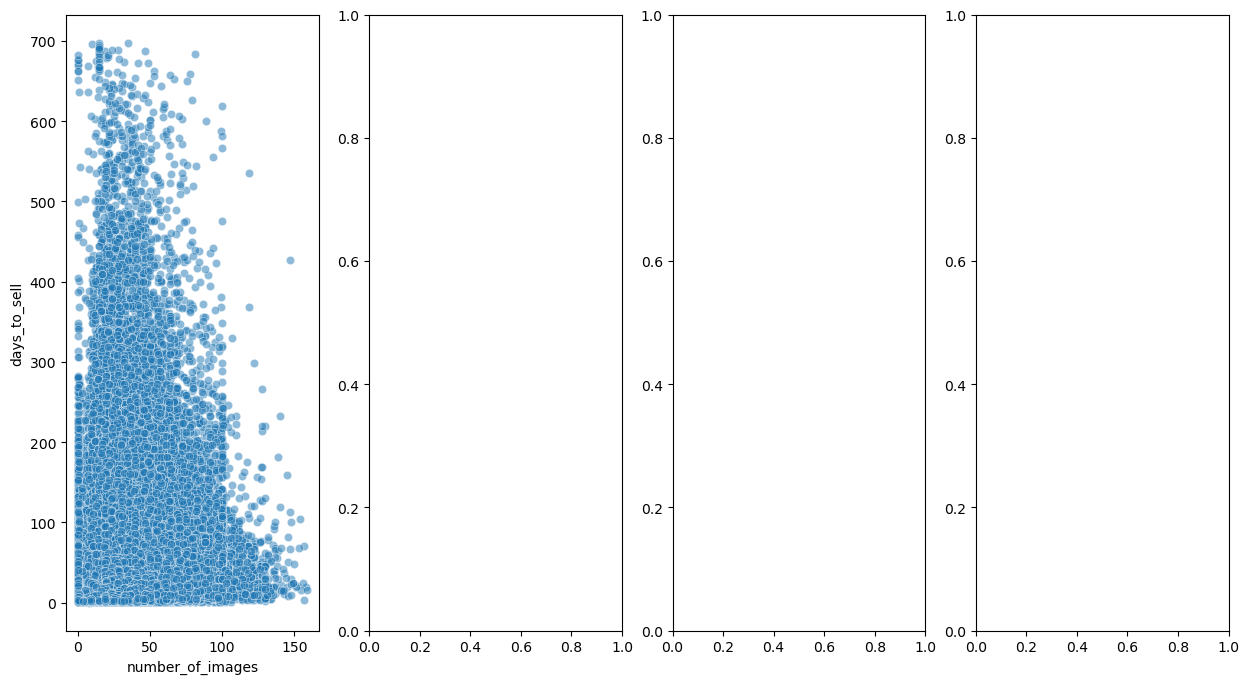

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,8))
sns.scatterplot(data=at, x='number_of_images', y='days_to_sell', alpha=0.5, ax=axs[0])
sns.scatterplot(data=at, x='first_date_seen', y='days_to_sell', alpha=0.5, ax=axs[1])
sns.scatterplot(data=at, x='top_speed_mph', y='days_to_sell', alpha=0.5, ax=axs[2])
sns.scatterplot(data=at, x='can_home_deliver', y='days_to_sell', alpha=0.5, ax=axs[3])

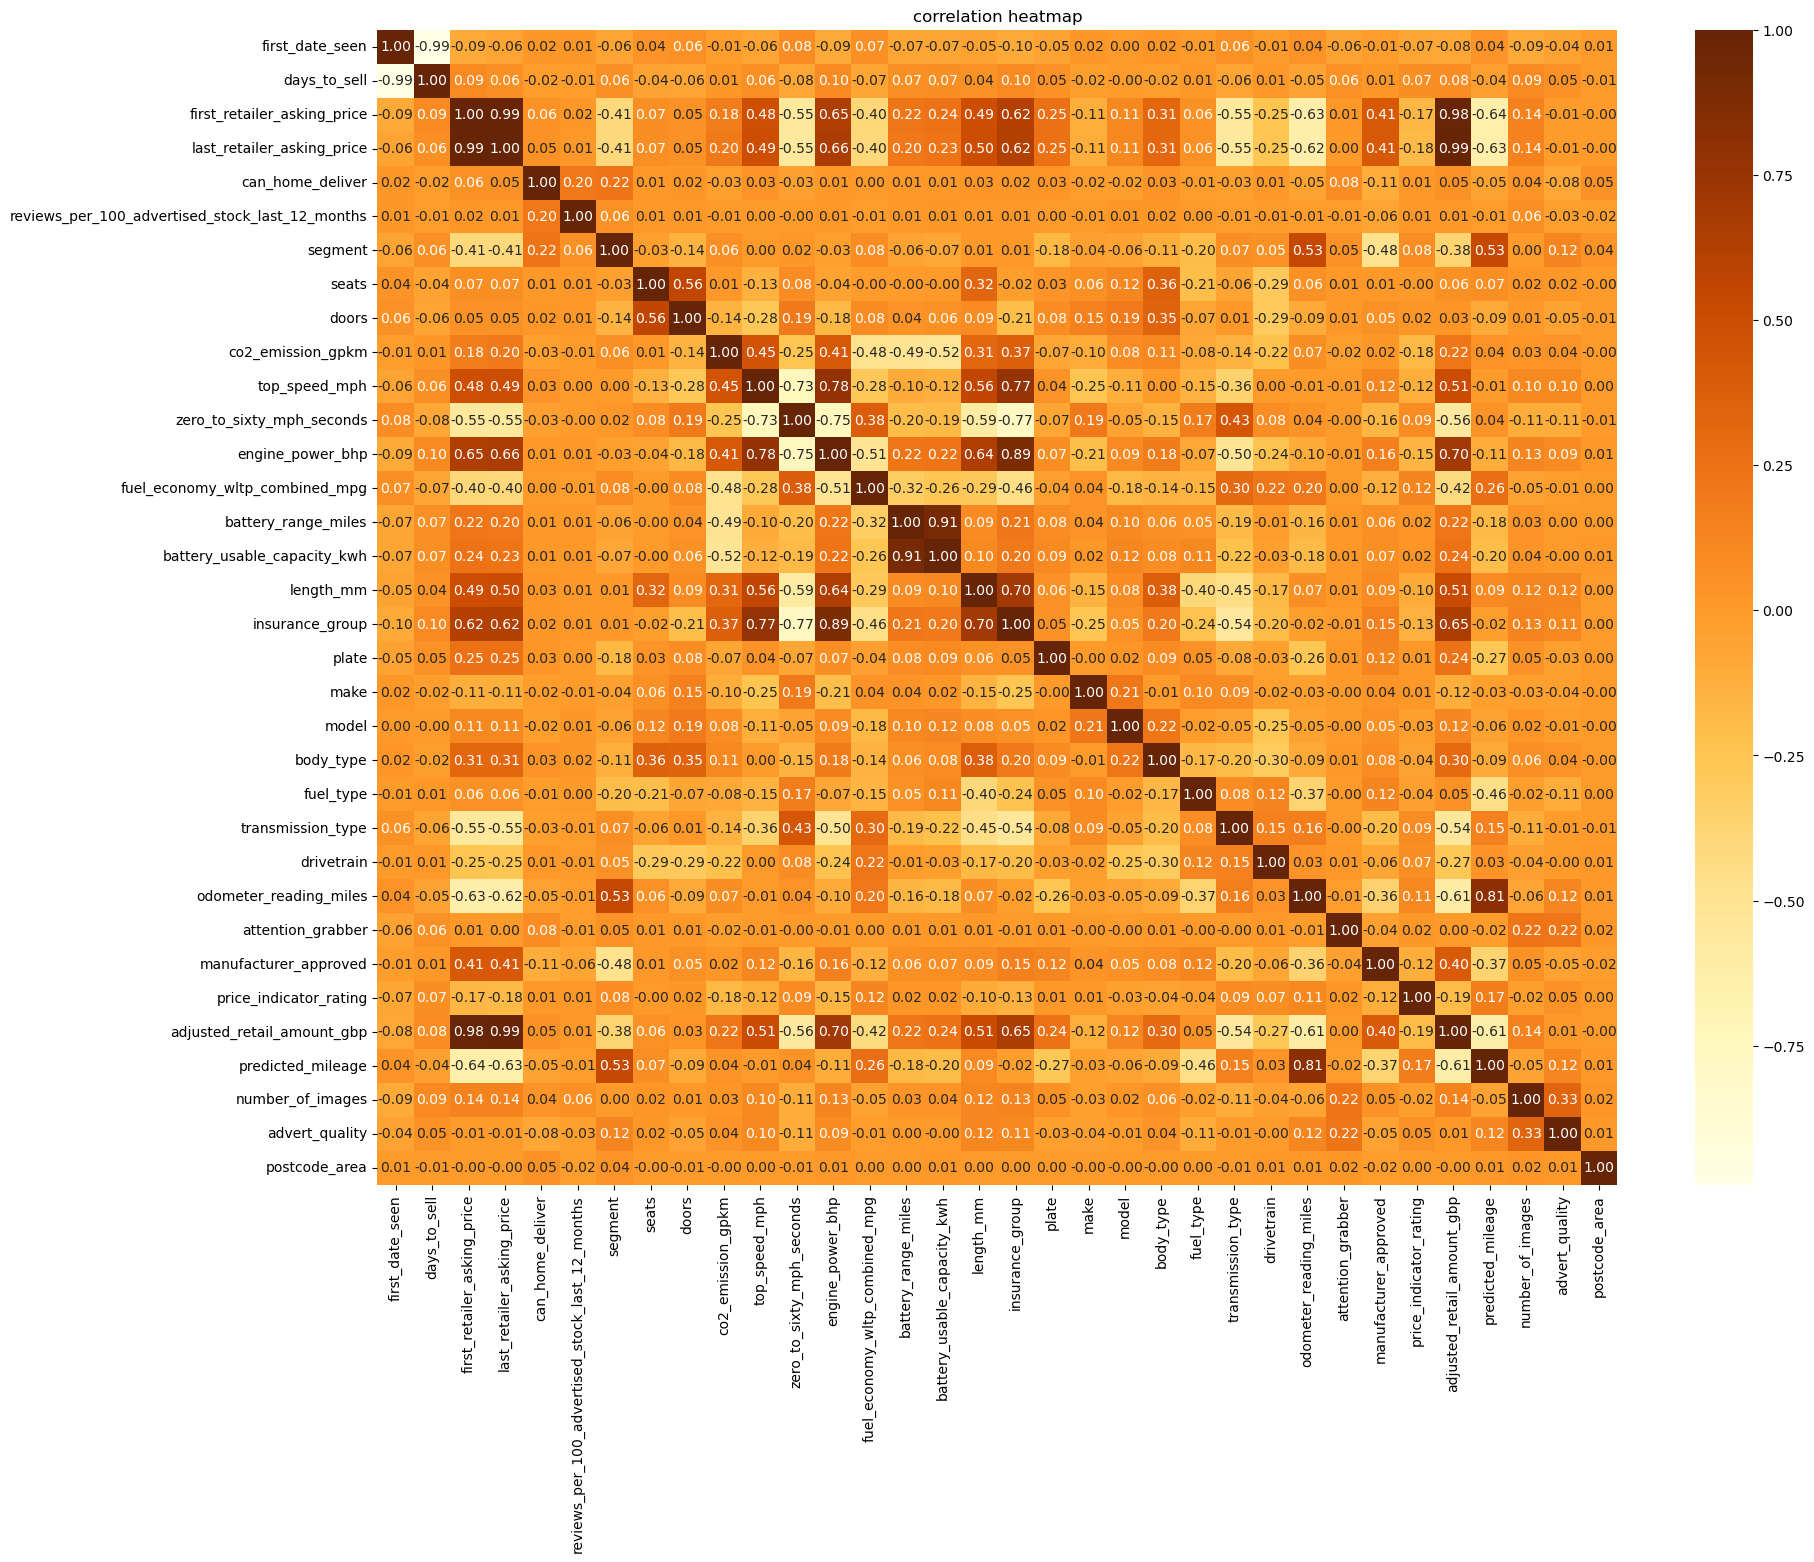

In [ ]:
plt.figure(figsize = (20, 15))
heatmap = sns.heatmap(at.corr(), annot = True, cmap = 'YlOrBr', fmt = '.2f')
plt.title('correlation heatmap')
plt.show()

<Axes: xlabel='days_to_sell', ylabel='Count'>

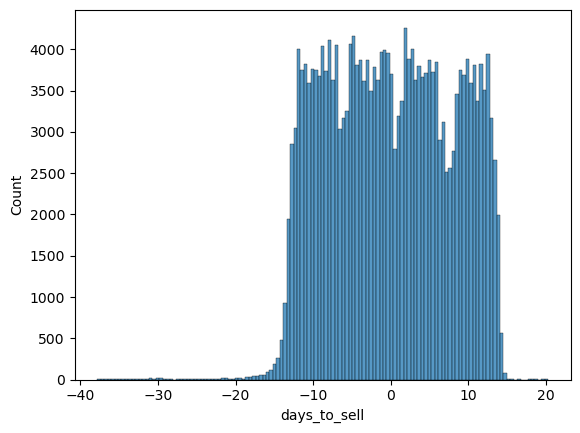

In [ ]:
residuals = Gsearch.predict(X) - y
sns.histplot(residuals)